In [336]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [337]:
# prompt: # prompt: # prompt: Make this function: def calc_net_irs_payoff(amortization_schedule, euribor_df, start_date, coupon, duration, frequency, premium): where the euribor df has rows Date (index), Rate e.g. 15/07/2025, 2.05 with no discounting. Use actual dates i.e. find the euribor date corresponding to the next coupon payment and not a simple frquency e.g. move 126 spots forward because there may be some gaps. The amortixation schedule is a simple array of the notional amount of the irs at each payment e.g. 100k 80k 60k for the first three periods (6m in the case of frequency 2). You should make the date calculations yourself regarding when these amortixations and payments take place

import pandas as pd
def calc_net_irs_payoff(amortization_schedule, euribor_df, start_date, coupon, duration, frequency, premium):
    """
    Calculates the net payoff of an IRS.

    Args:
        amortization_schedule (list): A list of notional amounts for each payment period.
        euribor_df (pd.DataFrame): DataFrame with 'Date' (index) and 'Rate' columns.
        start_date (str or datetime): The start date of the IRS.
        coupon (float): The fixed coupon rate of the IRS.
        duration (int): The duration of the IRS in years.
        frequency (int): The payment frequency per year.
        premium (float): Any upfront premium paid.

    Returns:
        float: The net payoff of the IRS.
    """
    start_date = pd.to_datetime(start_date)
    euribor_df.index = pd.to_datetime(euribor_df.index)

    num_payments = duration * frequency
    payoff = premium  # Start with the premium

    current_date = start_date

    for i in range(num_payments):
        # Find the next payment date
        payment_date = current_date
        for _ in range(365 // frequency): # Look ahead for a reasonable period
            payment_date += pd.Timedelta(days=1)
            if payment_date in euribor_df.index:
                break

        if payment_date not in euribor_df.index:
            print(f"Warning: Could not find a Euribor rate for payment date {payment_date}. Skipping payment calculation.", file=sys.stderr)
            current_date = payment_date # Move to the potentially missing date
            continue

        # Get the notional for this period
        if i < len(amortization_schedule):
            notional = amortization_schedule[i]
        else:
            print(f"Warning: Amortization schedule exhausted for payment {i+1}. Using last notional.", file=sys.stderr)
            notional = amortization_schedule[-1]


        # Get the Euribor rate for this payment date
        euribor_rate = euribor_df.loc[payment_date, 'Rate'] / 100.0

        # Calculate the fixed leg payment
        fixed_payment = notional * (coupon / frequency / 100)

        # Calculate the floating leg payment
        floating_payment = notional * (euribor_rate / frequency)

        # Calculate the net payment for this period
        net_payment = fixed_payment - floating_payment

        # Add to the total payoff (no discounting yet)
        payoff += net_payment

        # Move to the next payment date
        current_date = payment_date

    return payoff


In [338]:
# prompt: In a similar fashion to this function (# prompt: # prompt: # prompt: Make this function: def calc_net_irs_payoff(amortization_schedule, euribor_df, start_date, coupon, duration, frequency, premium): where the euribor df has rows Date (index), Rate e.g. 15/07/2025, 2.05. Use actual dates i.e. find the euribor date corresponding to the next coupon payment and not a simple frquency e.g. move 126 spots forward because there may be some gaps. The amortixation schedule is a simple array of the notional amount of the irs at each payment e.g. 100k 80k 60k for the first three periods (6m in the case of frequency 2). You should make the date calculations yourself regarding when these amortixations and payments take place), make another function calc_irs premium, which calculates the premium paid for the irs starting at that specific date, instead of the 6m euribor rate, you will be given the specific ATM rate for that date. You dont need the whole df so you will be given the specific float. Since you have the ATM rate and the coupon of the actual IRS, you can use it to calculate the expected discounted future cash flows and find the premium. Use the euribor 6m df if you think its a better discount rate

import pandas as pd
def calc_irs_premium(amortization_schedule, euribor_df, start_date, coupon, duration, frequency, atm_rate):
    """
    Calculates the expected premium of an IRS based on the ATM rate.

    Args:
        amortization_schedule (list): A list of notional amounts for each payment period.
        euribor_df (pd.DataFrame): DataFrame with 'Date' (index) and 'Rate' columns (used for discounting).
        start_date (str or datetime): The start date of the IRS.
        coupon (float): The fixed coupon rate of the IRS.
        duration (int): The duration of the IRS in years.
        frequency (int): The payment frequency per year.
        atm_rate (float): The At-The-Money (ATM) rate for the IRS tenor at the start date.

    Returns:
        float: The calculated premium of the IRS.
    """
    start_date = pd.to_datetime(start_date)
    euribor_df.index = pd.to_datetime(euribor_df.index)

    num_payments = duration * frequency
    expected_cash_flows = 0.0

    current_date = start_date

    for i in range(num_payments):
        # Find the next payment date
        payment_date = current_date
        for _ in range(365 // frequency): # Look ahead for a reasonable period
            payment_date += pd.Timedelta(days=1)
            if payment_date in euribor_df.index:
                break

        if payment_date not in euribor_df.index:
            print(f"Warning: Could not find a Euribor rate for payment date {payment_date}. Skipping payment calculation.", file=sys.stderr)
            current_date = payment_date # Move to the potentially missing date
            continue

        # Get the notional for this period
        if i < len(amortization_schedule):
            notional = amortization_schedule[i]
        else:
            print(f"Warning: Amortization schedule exhausted for payment {i+1}. Using last notional.", file=sys.stderr)
            notional = amortization_schedule[-1]

        # Calculate the net cash flow for this period using the ATM rate
        # The expected floating leg payment is based on the ATM rate for the full term
        # or more accurately, the forward rates implied by the yield curve if available.
        # For simplicity here, we'll use the ATM rate as a proxy for expected floating rate.
        # A more accurate approach would use forward rates derived from the discount curve.

        # Using the ATM rate for the expected floating payment for simplicity
        # This is a simplification. A proper calculation would use forward rates.
        expected_floating_payment = notional * (atm_rate / frequency / 100)
        fixed_payment = notional * (coupon / frequency / 100)

        net_cash_flow = fixed_payment - expected_floating_payment

        # Get the discount rate for this payment date
        # Using the Euribor rate at the payment date for discounting
        discount_rate = euribor_df.loc[payment_date, 'Rate'] / 100.0
        time_to_payment = (payment_date - start_date).days / 365.0

        # Calculate the discount factor
        discount_factor = 1 / (1 + discount_rate)**time_to_payment # Simple annual discounting

        # Add the discounted cash flow to the total
        expected_cash_flows += net_cash_flow * discount_factor

        # Move to the next payment date
        current_date = payment_date

    # The premium is the negative of the sum of the expected discounted cash flows
    premium = -expected_cash_flows

    return premium

                      MTM
Date                     
2018-05-17  882065.625812
2018-05-18  880268.347109
2018-05-21  879882.371113
2018-05-22  880000.703623
2018-05-23  878633.519846
...                   ...
2019-12-23  858993.081368
2019-12-24  858997.425728
2019-12-27  858658.346874
2019-12-30   859869.55188
2019-12-31  860249.680192

[416 rows x 1 columns]
Date
2025-07-10    2.070
2025-07-09    2.051
2025-07-08    2.019
2025-07-07    2.016
2025-07-04    2.026
              ...  
1999-01-06    3.197
1999-01-05    3.204
1999-01-04    3.223
1998-12-31    3.233
1998-12-30    3.230
Name: Rate, Length: 6794, dtype: float64
133668.1
-111253.54303994951


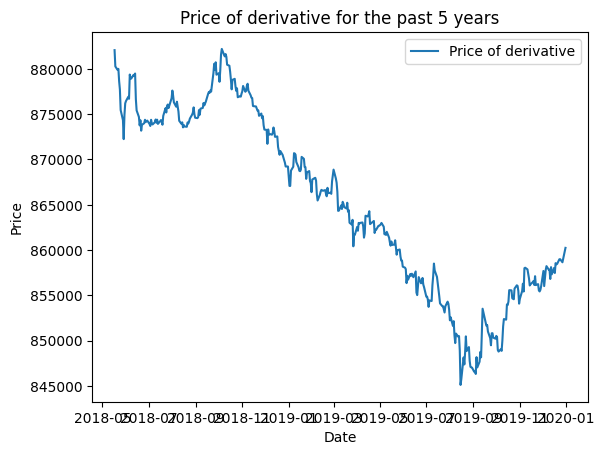

In [339]:
data = pd.DataFrame(columns=['Date', 'MTM'])
euribor_df = pd.read_csv('6m_euribor.csv')
atm_rates = pd.read_csv('5y_ATM_IRS.csv')

# data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
euribor_df['Date'] = pd.to_datetime(euribor_df['Date'], format='%Y-%m-%d')
data.set_index('Date', inplace=True)
data = data.sort_values('Date', ascending=True)

atm_rates['Date'] = pd.to_datetime(atm_rates['Date'], dayfirst=False)
atm_rates.set_index('Date', inplace=True)
atm_rates = atm_rates.sort_values('Date', ascending=True)

euribor_df.set_index('Date', inplace=True)
euribor_df.dropna(inplace=True, subset=['Rate'])
euribor_df = euribor_df.sort_values('Date', ascending=False)

start_date = '2016-05-01'
end_date = '2020-01-01'
coupon = 2.87
amort_schedule = [960000, 940000, 920000, 900000, 875000, 850000, 820000, 790000, 750000, 710000]

dates = pd.date_range(start_date, end_date, freq='D')

avg_notional = np.mean(amort_schedule)

# print(euribor_df.head())
for date in dates:
    if date in euribor_df.index:
      if date in atm_rates.index and date in euribor_df.index:
        rate = euribor_df.loc[date, 'Rate'] / 100.0
        atm_rate = atm_rates.loc[date, 'Price']
        premium = calc_irs_premium(amort_schedule, euribor_df, date, coupon, 5, 2, atm_rate)
        total_cashflows = calc_net_irs_payoff(amort_schedule, euribor_df, date, coupon, 5, 2, premium)
        data.loc[date, 'MTM'] = total_cashflows + np.mean(amort_schedule)

print(data)

print(euribor_df['Rate'])

print(calc_net_irs_payoff(amort_schedule, euribor_df, '07/01/2018', 2.87, 5, 2, 0))

print(calc_irs_premium(amort_schedule, euribor_df, '07/01/2018', 2.87, 5, 2, 0.257))

plt.plot(data.index, data['MTM'], label='Price of derivative')
plt.title('Price of derivative for the past 5 years')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [340]:
data['Returns'] = (data['MTM'] - data['MTM'].shift(1)) / data['MTM'].shift(1)
data['Log_Returns'] = data['Returns'].apply(lambda x: np.log(1+x))
data.head()

,MTM,Returns,Log_Returns
Date,,,
2018-05-17,882065.625812,NaN,NaN
2018-05-18,880268.347109,-0.002038,-0.002040
2018-05-21,879882.371113,-0.000438,-0.000439
2018-05-22,880000.703623,0.000134,0.000134
2018-05-23,878633.519846,-0.001554,-0.001555


In [341]:
def create_scenario(no_of_points, dataframe, multiplier):
  daily_returns = dataframe['Log_Returns'].tolist()
  scenario = pd.Series(dtype=float)
  sum = 0
  for i in range(no_of_points):
    scenario[i] = np.random.choice(daily_returns) * multiplier
    sum += scenario[i]
  return np.var(scenario), sum


In [342]:
def create_scenario_optimized(no_of_points, dataframe, multiplier):
    rng = np.random.default_rng()
    returns = df['Log_Returns'].to_numpy(dtype=np.float64)

    samples  = rng.choice(returns, size=no_of_points)
    scaled   = samples * multiplier

    return np.var(scaled), scaled.sum()

In [343]:
def simulate(no_of_scenarios, no_of_points, dataframe, multiplier = 1):
  sum_list = pd.Series(dtype=float)
  for i in range(no_of_scenarios):
    sys.stdout.write(f'\rSimulations completed: {i + 1}/{no_of_scenarios}')
    sys.stdout.flush()
    var, sum = create_scenario(no_of_points, dataframe, multiplier)
    sum_list[i] = np.exp(sum)
    if multiplier != 1:
      sum_list[i] -= 0.5 * no_of_points * var
  return sum_list

In [344]:
def simulate_optimized(no_of_scenarios, no_of_points, dataframe, multiplier = 1, chunk=None):
    rng      = np.random.default_rng()
    returns  = dataframe["Log_Returns"].to_numpy(dtype=np.float64, copy=False)

    if chunk is None or chunk >= no_of_scenarios:
        samples = rng.choice(returns,
                             size=(no_of_scenarios, no_of_points)) * multiplier
        sums = samples.sum(axis=1)
        vars = samples.var(axis=1)
        out  = np.exp(sums)
        if multiplier != 1:
            out -= 0.5 * no_of_points * vars
        return pd.Series(out, index=range(no_of_scenarios))

    out   = np.empty(no_of_scenarios, dtype=np.float64)
    done  = 0
    while done < no_of_scenarios:
        n      = min(chunk, no_of_scenarios - done)
        block  = rng.choice(returns, size=(n, no_of_points)) * multiplier
        sums   = block.sum(axis=1)
        vars   = block.var(axis=1)
        out[done:done + n] = np.exp(sums)
        if multiplier != 1:
            out[done:done + n] -= 0.5 * no_of_points * vars
        done += n

    return pd.Series(out, index=range(no_of_scenarios))

In [345]:
def identify_stress_benchmark(dataframe, rolling_period = 63, quantile = 0.95):
  rolling_std = dataframe['Log_Returns'].rolling(rolling_period).std()

  return rolling_std.quantile(quantile)

In [346]:
def calculate_scenarios(dataframe, stress_rolling_period = 63, chunk=50000, stress_quantile=0.95, no_of_points = 252, no_of_scenarios = 10000, notional=None):
  list_of_simulations = simulate_optimized(no_of_scenarios, no_of_points, dataframe, chunk=chunk)

  unfavourable = list_of_simulations.quantile(0.1)
  moderate = list_of_simulations.quantile(0.5)
  favourable = list_of_simulations.quantile(0.9)

  if notional is not None:
    unfavourable_monetary = (list_of_simulations.quantile(0.1) - 1 ) * notional
    moderate_monetary = (list_of_simulations.quantile(0.5) - 1 ) * notional
    favourable_monetary = (list_of_simulations.quantile(0.9) - 1 ) * notional

  print('Unfavourable: ', str(round((unfavourable - 1)*100, 2)), '%')
  print('Moderate: ', str(round((moderate - 1)*100, 2)), '%')
  print('Favourable: ', str(round((favourable - 1)*100, 2)), '%')

  if notional is not None:
    print('\nUnfavourable Monetary: ', str(round(unfavourable_monetary, 2)), '€')
    print('Moderate Monetary: ', str(round(moderate_monetary, 2)), '€')
    print('Favourable Monetary: ', str(round(favourable_monetary, 2)), '€')

  stress_benchmark = identify_stress_benchmark(dataframe, stress_rolling_period, stress_quantile)

  stress_list_of_simulations = simulate_optimized(no_of_scenarios, no_of_points, dataframe, stress_benchmark/dataframe['Log_Returns'].std())

  stress = stress_list_of_simulations.quantile(0.05)

  stress = min(stress, unfavourable)

  if notional is not None:
    stress_monetary = (stress - 1) * notional

  print('\nStress: ', str(round((stress - 1) * 100, 2)), '%')
  if notional is not None:
          print('Stress Monetary: ', str(round(stress_monetary, 2)), '€')

  return unfavourable, moderate, favourable, stress

In [347]:
scenarios = 10000
days_per_scenario = 252
stress_rolling_period = 63
stress_quantile = 0.95
chunk = None # If the program crashes from no memory, change to 100000.

scenarios = calculate_scenarios(data, no_of_scenarios=scenarios, no_of_points = days_per_scenario, stress_rolling_period = stress_rolling_period, stress_quantile=stress_quantile, chunk=chunk, notional=avg_notional)

Unfavourable:  -3.46 %
Moderate:  -1.51 %
Favourable:  0.49 %

Unfavourable Monetary:  -29440.74 €
Moderate Monetary:  -12874.45 €
Favourable Monetary:  4158.08 €

Stress:  -5.34 %
Stress Monetary:  -45455.42 €
